# EEG Emotion Art Generator - Inference Only

Questo notebook illustra un flusso completo per l’analisi e la classificazione delle emozioni a partire da segnali EEG. In particolare, si parte dal caricamento di un modello di classificazione pre-addestrato, il cui training è stato effettuato in un notebook separato denominato `EEG Emotion Classifier`, specifico per segnali EEG. Successivamente, viene caricato e preprocessato un singolo campione EEG estratto da un file CSV, che viene scalato e preparato per l’inferenza. Il modello viene quindi utilizzato per prevedere le probabilità delle classi emotive (negative, neutrali, positive), e l’emozione dominante viene individuata.

Per migliorare l’accuratezza e la robustezza della classificazione, viene applicata una logica fuzzy che raffina la stima dell’emozione dominante, fornendo anche un valore di intensità fuzzy. A seguire, il notebook genera un’immagine astratta rappresentativa dello stato emotivo rilevato, utile per una visualizzazione creativa del risultato. Infine, viene mostrata l’importanza delle feature EEG usate dal modello nella classificazione, evidenziando quali segnali hanno avuto maggiore influenza nella predizione finale.

**File necessari per il funzionamneto:**

*   `eeg_sample.csv`(il segnale da classificare)
*   `emotion_classifier_model.keras` (il modello di rete neurale addestrato)
*   `scaler.pkl`(scaler usato in fase di addestramento)
*   `support_function.py`(funzioni di supporto richiamate)

## 0: Setup Iniziale e Importazione Librerie


In [1]:
# Installazione delle librerie
!pip install -q pandas numpy scikit-learn tensorflow Pillow scikit-fuzzy matplotlib seaborn

print("\nLibrerie installate con successo!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 7.4 MB/s eta 0:00:00

Librerie installate con successo!


In [2]:
# Accesso a Google Drive
from google.colab import drive
import sys

# Analisi e manipolazione dei dati
import pandas as pd
import numpy as np
import os

# Visualizzazione dei dati
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing e modellazione con Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Costruzione, addestramento e salvataggio di modelli con TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Logica fuzzy con SciKit-Fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Manipolazione di immagini
from PIL import Image, ImageDraw
from IPython.display import display

# Operazioni casuali
import random

# Rimozione warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

## 1: Collegamento a Google Drive e Importazione File Necessari


In [3]:
# Monta Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Percorso base del progetto su Google Drive ---
base_path = "/content/drive/MyDrive/Colab Notebooks/IA FROM ENGINEERING TO ARTS/INFERENZA"

# --- Sottocartelle ---
support_path = os.path.join(base_path, "FILE DI SUPPORTO")
sample_path = os.path.join(base_path, "EEG SAMPLE")

# --- Aggiunta support_path al sys.path se non già presente ---
if support_path not in sys.path:
    sys.path.append(support_path)

# --- Import del modulo di supporto ---
import support_function

# --- File paths ---
input_eeg_file = os.path.join(sample_path, "eeg_sample_negative.csv")
config_modello = os.path.join(support_path, "emotion_classifier_model.keras")
scaler_path = os.path.join(support_path, "scaler.pkl")

print(f"Importazione avvenuta con Successo.")

Importazione avvenuta con Successo.


## 2: Inizializzazione e Setup dell'Ambiente


In [5]:
# Numero di classi emotive
num_classes = 3  # NEGATIVE, NEUTRAL, POSITIVE

# Caricamento struttura dati EEG (colonne)
if os.path.exists(input_eeg_file):
    single_eeg_df = pd.read_csv(input_eeg_file)
    eeg_cols = single_eeg_df.columns.tolist()
    print(f"Nomi colonne EEG caricati da {os.path.basename(input_eeg_file)}.")
else:
    eeg_cols = [f'feature_{i}' for i in range(2548)]
    print("File EEG non trovato. Nomi colonne EEG impostati come placeholder.")

# Inizializzazione del LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(["NEGATIVE", "NEUTRAL", "POSITIVE"]);

print(f"\nNumero di colonne EEG: {len(eeg_cols)}")
print(f"\nNumero di classi emotive: {num_classes}")
print(f"\nClassi emotive codificate: {label_encoder.classes_}")

Nomi colonne EEG caricati da eeg_sample_negative.csv.

Numero di colonne EEG: 2548

Numero di classi emotive: 3

Classi emotive codificate: ['NEGATIVE' 'NEUTRAL' 'POSITIVE']


## 3: Flusso di Inferenza per un Singolo Campione EEG


### Configurazione del Segnale EEG e Pre-Elaborazione dei dati
Estrazione di un singolo campione EEG, seguito dal caricamento dello scaler pre-addestrato e applicazione dello scaling per normalizzare i dati in ingresso al modello.

In [6]:
# Caricamento del Campione
my_single_eeg_sample_raw = single_eeg_df.iloc[0].values
print(f"\nCampione EEG caricato da {os.path.basename(input_eeg_file)}.")


# Caricamento dello Scaler e Scaling del Campione
scaler = joblib.load(scaler_path)

new_eeg_scaled_sample = scaler.transform(my_single_eeg_sample_raw.reshape(1, -1))
print("\nSegnale EEG scalato correttamente.")

print(f"\nForma del campione EEG originale: {my_single_eeg_sample_raw.shape}")
print(f"\nForma del campione EEG scalato: {new_eeg_scaled_sample.shape}")


Campione EEG caricato da eeg_sample_negative.csv.

Segnale EEG scalato correttamente.

Forma del campione EEG originale: (2548,)

Forma del campione EEG scalato: (1, 2548)


### Classificazione del Segnale (Rete Neurale)
Caricamento del modello neurale pre-addestrato e predizione delle probabilità delle classi emotive per il campione scalato. Identificazione e stampa dell’emozione dominante.

In [7]:
# Caricamento del modello
model = load_model(config_modello)
print("\nModello emotion_classifier_model.keras caricato con successo.\n")

# Classificazione
emotion_probabilities = model.predict(new_eeg_scaled_sample)[0]
predicted_class_idx = np.argmax(emotion_probabilities)
predicted_emotion_label = label_encoder.inverse_transform([predicted_class_idx])[0]

# Stampa formattata delle probabilità emotive (con 4 cifre decimali)
print("\nProbabilità emozioni:\n")
for emotion, prob in zip(label_encoder.classes_, emotion_probabilities):
    print(f"  → {emotion}: {prob:.4f}")

print(f"\nEmozione dominante predetta: {predicted_emotion_label}")


Modello emotion_classifier_model.keras caricato con successo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

Probabilità emozioni:

  → NEGATIVE: 1.0000
  → NEUTRAL: 0.0000
  → POSITIVE: 0.0000

Emozione dominante predetta: NEGATIVE


### Implementazione della Logica Fuzzy (Raffinamento dell’emozione)
Utilizzo di una funzione fuzzy per interpretare le probabilità predette, restituendo un’etichetta di emozione dominante più sfumata e un valore di intensità fuzzy.




Emozione dominante raffinata (fuzzy logic):

   → Etichetta: NEGATIVE
   → Intensità (valore fuzzy): 0.17





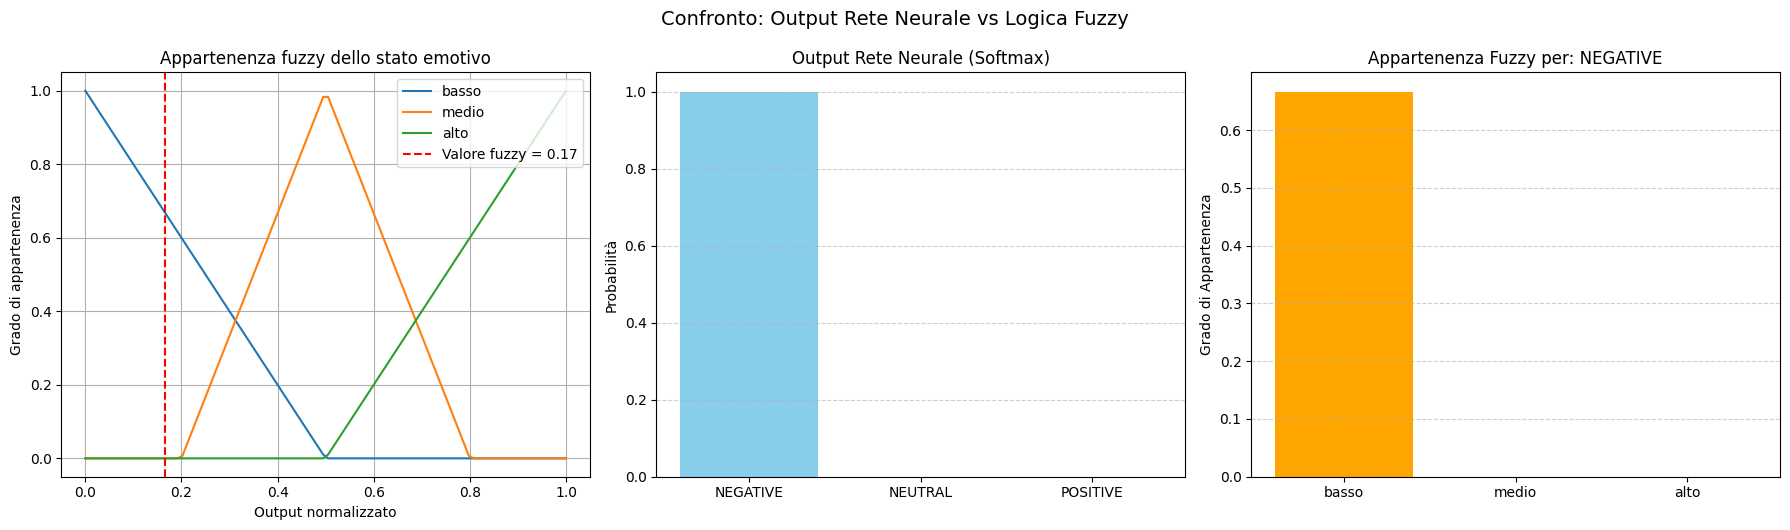

In [8]:
# Calcolo dell'emozione dominante con logica fuzzy
dominant_emotion_fuzzy, fuzzy_value = support_function.get_fuzzy_emotion_state(
    emotion_probabilities,
    list(label_encoder.classes_)
)

#  Output risultato fuzzy
if dominant_emotion_fuzzy is not None:
    print("\nEmozione dominante raffinata (fuzzy logic):\n")
    print(f"   → Etichetta: {dominant_emotion_fuzzy}")
    print(f"   → Intensità (valore fuzzy): {fuzzy_value:.2f}\n\n\n")
else:
    print("\nErrore nella logica fuzzy: impossibile determinare l'emozione.")


# Grafico per interpretabilità della logica Fuzzy
x = np.linspace(0, 1, 100)
x_fuzzy = np.arange(0, 1.01, 0.01)

basso = fuzz.trimf(x_fuzzy, [0, 0, 0.5])
medio = fuzz.trimf(x_fuzzy, [0.2, 0.5, 0.8])
alto = fuzz.trimf(x_fuzzy, [0.5, 1, 1])

mu_basso = fuzz.interp_membership(x_fuzzy, basso, fuzzy_value)
mu_medio = fuzz.interp_membership(x_fuzzy, medio, fuzzy_value)
mu_alto  = fuzz.interp_membership(x_fuzzy, alto, fuzzy_value)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 grafici affiancati

# Primo grafico: curve fuzzy + linea verticale
axs[0].plot(x, fuzz.trimf(x, [0,0,0.5]), label='basso')
axs[0].plot(x, fuzz.trimf(x, [0.2,0.5,0.8]), label='medio')
axs[0].plot(x, fuzz.trimf(x, [0.5,1,1]), label='alto')
axs[0].axvline(fuzzy_value, color='red', linestyle='--', label=f'Valore fuzzy = {fuzzy_value:.2f}')
axs[0].set_title('Appartenenza fuzzy dello stato emotivo')
axs[0].set_xlabel('Output normalizzato')
axs[0].set_ylabel('Grado di appartenenza')
axs[0].legend()
axs[0].grid(True)

# Secondo grafico: barre probabilità rete neurale (softmax)
emotion_labels = list(label_encoder.classes_)
axs[1].bar(emotion_labels, emotion_probabilities, color='skyblue')
axs[1].set_title('Output Rete Neurale (Softmax)')
axs[1].set_ylabel('Probabilità')
axs[1].grid(axis='y', linestyle='--', alpha=0.6)

# Terzo grafico: barre appartenenza fuzzy
linguistic_labels = ['basso', 'medio', 'alto']
fuzzy_memberships = [mu_basso, mu_medio, mu_alto]
axs[2].bar(linguistic_labels, fuzzy_memberships, color='orange')
axs[2].set_title(f'Appartenenza Fuzzy per: {dominant_emotion_fuzzy}')
axs[2].set_ylabel('Grado di Appartenenza')
axs[2].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.suptitle('Confronto: Output Rete Neurale vs Logica Fuzzy', fontsize=14, y=1.05)
plt.show()


### Generazione dell'Immagine Astratta in base all'emozione
Generazione e salvataggio di un’immagine di arte astratta parametrizzata sull’emozione dominante fuzzy e relativa intensità,


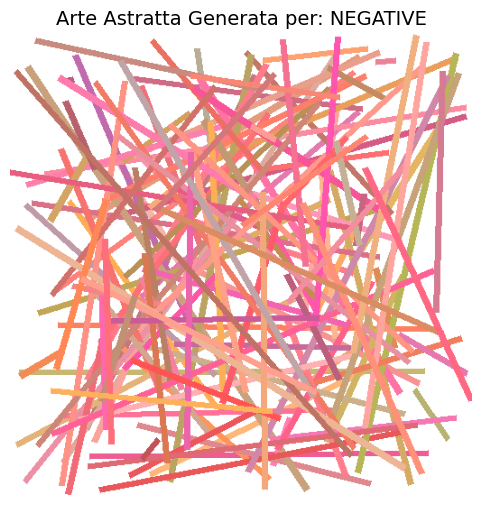


Arte astratta generata e salvata come 'abstract_art_NEGATIVE.png'.




In [9]:
if dominant_emotion_fuzzy is not None:

    # Generazione immagine
    art_image = support_function.generate_abstract_art(dominant_emotion_fuzzy, fuzzy_value)

    # Costruzione del nome del file
    art_path = f'abstract_art_{dominant_emotion_fuzzy.replace(" ", "_")}.png'

    # Salvataggio immagine
    art_image.save(art_path)

    # Visualizzazione immagine con titolo sopra
    plt.figure(figsize=(6,6))
    plt.title(f'Arte Astratta Generata per: {dominant_emotion_fuzzy}', fontsize=14)
    plt.axis('off')
    img = Image.open(art_path)
    plt.imshow(img)
    plt.show()

    print(f"\nArte astratta generata e salvata come '{art_path}'.\n\n")

else:
    print("\nImpossibile generare arte astratta: emozione fuzzy non valida.")


### Interpretabilità (Feature Importance con Grad-CAM)
Grad-CAM (Gradient-weighted Class Activation Mapping) è una tecnica di interpretabilità che aiuta a visualizzare quali parti dell'input hanno influenzato maggiormente la decisione di una rete neurale. Sebbene Grad-CAM sia comunemente usato con le reti neurali convoluzionali (CNN) per le immagini, il concetto può essere adattato per comprendere l'importanza delle caratteristiche (in questo caso, i canali EEG) in un modello di rete neurale feed-forward.
Per un modello feed-forward come quello che abbiamo costruito, l'applicazione diretta di Grad-CAM richiede un'interpretazione leggermente diversa. Non abbiamo strati convoluzionali da cui estrarre le mappe di attivazione. Tuttavia, possiamo simulare un concetto simile calcolando i gradienti rispetto all'ultimo strato convoluzionale (o in questo caso, l'ultimo strato denso prima dell'output) e pesandoli con le attivazioni.
**Nota:** L'implementazione standard di Grad-CAM è più efficace e intuitiva per i modelli CNN che elaborano dati spaziali (come le immagini). Per i dati EEG, che sono sequenziali o multicanale, l'interpretazione di Grad-CAM potrebbe richiedere una visualizzazione specifica per i segnali nel tempo o per i canali.


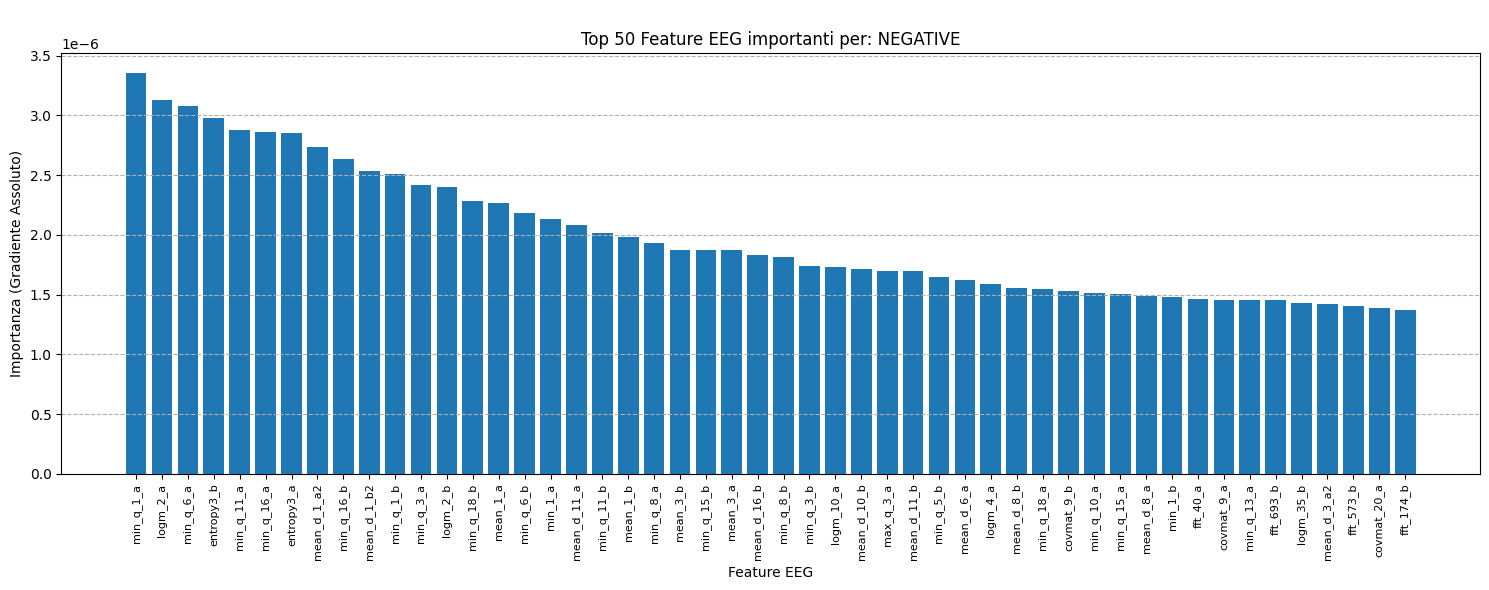

Grafico importanza feature salvato come 'feature_importance_NEGATIVE.png'.


In [10]:
# Feature Importance
if dominant_emotion_fuzzy is not None:

    # Calcolo dell'importanza delle feature EEG rispetto alla classe predetta (gradiente)
    importance_map = support_function.compute_feature_importance_ffnn(
        model, new_eeg_scaled_sample[0], predicted_class_idx
    )

    plt.figure(figsize=(15, 6))

    # Se le feature EEG sono > 50, visualizza solo le 50 più rilevanti
    if len(eeg_cols) > 50:
        sorted_idx = np.argsort(importance_map)[::-1][:50]  # Indici top 50 feature per importanza
        cols_display = [eeg_cols[i] for i in sorted_idx]    # Nomi delle feature selezionate
        imp_display = importance_map[sorted_idx]            # Valori di importanza corrispondenti
        plt.bar(cols_display, imp_display)
        plt.xticks(rotation=90, fontsize=8)
        plt.title(f'\nTop 50 Feature EEG importanti per: {predicted_emotion_label}')
    else:
        # Se il numero di feature è ≤ 50, visualizza tutte
        plt.bar(eeg_cols, importance_map)
        plt.xticks(rotation=90, fontsize=10)
        plt.title(f'Importanza Feature EEG per: {predicted_emotion_label}')

    # Etichette e layout grafico
    plt.xlabel('Feature EEG')
    plt.ylabel('Importanza (Gradiente Assoluto)')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    # Salvataggio del grafico in un file PNG
    importance_path = f'feature_importance_{predicted_emotion_label.replace(" ", "_")}.png'
    plt.savefig(importance_path)
    plt.show()

    print(f"Grafico importanza feature salvato come '{importance_path}'.")
